# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/mpnet-base-trans.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
_mixout = 0.9
EXP_NAME = f"microsoft-deberta-v3-attention2"


In [3]:
# !nvidia-smi
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/deberta-v3-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    mixout = True
    mixout_prob = _mixout
    pass_fold = [None]
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    if os.path.exists(filename):
        os.remove(filename)
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

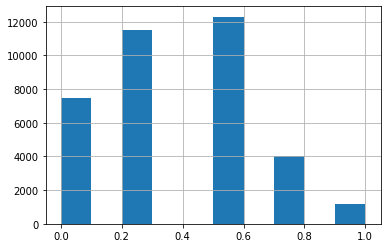

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         # self.cnn = nn.Sequential(
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         #     nn.ReLU(),
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         # )
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         # last_hidden_states = outputs[0]
#         last_hidden_states = outputs["last_hidden_state"]#.permute(0, 2, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         # output = self.cnn(feature)

#         return output

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            token_embeddings_size = len(CFG.tokenizer)
            self.model.resize_token_embeddings(token_embeddings_size)
        else:
            self.model = AutoModel.from_config(self.config)

        self.fc_dropout1 = nn.Dropout(0.1)
        self.fc_dropout2 = nn.Dropout(0.2)
        self.fc_dropout3 = nn.Dropout(0.3)
        self.fc_dropout4 = nn.Dropout(0.4)
        self.fc_dropout5 = nn.Dropout(0.5)

        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        # これがいわゆるattention pool
        # https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324330
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, self.config.hidden_size),
            nn.LayerNorm(self.config.hidden_size),
            nn.GELU(),
            nn.Linear(self.config.hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)

        feature1 = self.fc_dropout1(feature)
        feature2 = self.fc_dropout2(feature)
        feature3 = self.fc_dropout3(feature)
        feature4 = self.fc_dropout4(feature)
        feature5 = self.fc_dropout5(feature)

        feature_all = (feature1+feature2+feature3+feature4+feature5)/5
        output = self.fc(feature_all)
        
        return output

In [25]:
# class CustomModel(nn.Module):#cat dim=1
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         # self.use_last_hidden_num = 3
#         self.use_last_hidden_num = 2
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size*self.use_last_hidden_num, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = torch.cat([outputs["hidden_states"][-1*i] for i in range(1, self.use_last_hidden_num+1)],dim=1)
        
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)

#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         # output = self.cnn(feature)
#         return output

In [26]:
# class CustomModel(nn.Module):# cat dim=2
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         # self.use_last_hidden_num = 3
#         self.use_last_hidden_num = 2
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        
#         # self.lstm = nn.LSTM(self.config.hidden_size, self.config.hidden_size, batch_first=True)
#         # self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self.fc = nn.Sequential(
#             # nn.Linear(self.config.hidden_size*4,self.config.hidden_size*3),
#             # nn.Linear(self.config.hidden_size*3,self.config.hidden_size*2),
#             # nn.Linear(self.config.hidden_size*2,self.config.hidden_size),
#             nn.Linear(self.config.hidden_size*self.use_last_hidden_num, 1)
#         )
#         # self.cnn = nn.Sequential(
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         #     nn.ReLU(),
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         # )
#         self._init_weights(self.fc)
#         # self._init_weights(self.lstm)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size*self.use_last_hidden_num, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         # last_hidden_states = outputs[0]
#         # last_hidden_states = outputs["last_hidden_state"]
#         last_hidden_states = torch.cat([outputs["hidden_states"][-1*i] for i in range(1, self.use_last_hidden_num+1)],dim=2)
        
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         # output = self.cnn(feature)
#         return output

In [27]:
# class TransformerHead(nn.Module):
#     def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
#         super().__init__()

#         self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
#                                                                                           nhead=nhead),
#                                                  num_layers=num_layers)
#         self.row_fc = nn.Linear(in_features, 1)
#         self.out_features = max_length

#     def forward(self, x):
#         out = self.transformer(x)
#         out = self.row_fc(out).squeeze(-1)
#         return out

In [28]:
# class CustomModel(nn.Module):# cat lstm
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        
#         self.lstm = nn.LSTM(self.config.hidden_size*4, self.config.hidden_size*4, batch_first=True)
#         self.fc = nn.Linear(self.config.hidden_size*4, self.cfg.target_size)
#         # self.cnn = nn.Sequential(
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         #     nn.ReLU(),
#         #     nn.Conv1d(self.config.hidden_size, 256, kernel_size=2, padding=1),
#         # )
#         self._init_weights(self.fc)
#         self._init_weights(self.lstm)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size*4, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         # last_hidden_states = outputs[0]
#         # last_hidden_states = outputs["last_hidden_state"]
#         # last_hidden_states = torch.cat([outputs["hidden_states"][-1*i] for i in range(1, 4+1)],dim=1)
#         last_hidden_states = torch.cat([outputs["hidden_states"][-1*i] for i in range(1, 4+1)],dim=2)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs).unsqueeze(1)
#         feature, _ = self.lstm(feature, None)
#         feature = feature[:, -1, :]
#         output = self.fc(self.fc_dropout(feature))
#         # output = self.cnn(feature)

#         return output

In [29]:
# import sys
# sys.path.append("../../modules/mixout")
# from mixout import MixLinear, Mixout

In [30]:
# class CustomModelTransformer(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
        
#         try:
#             self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
#         except:
#             self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model,)
#             self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
#         in_features = self.feature_extractor.classifier.in_features
#         self.attention = TransformerHead(in_features=in_features, max_length=133, num_layers=1, nhead=8, num_targets=1)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         # last_hidden_states = outputs[0]
#         last_hidden_states, _ = outputs['last_hidden_state'].max(1)
#         # feature = torch.mean(last_hidden_states, 1)
#         feature = self.attention(last_hidden_states)
#         return feature


#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
        
#         return output

# Helpler functions

In [31]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if "train" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)

        model.to(device)                
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [32]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):

    # ====================================================
    # model & optimizer
    # ====================================================
    if "transformer" in EXP_NAME:
        model = CustomModelTransformer(CFG, config_path=None, pretrained=True)
    else:
        model = CustomModel(CFG, config_path=None, pretrained=True)
    if "all" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)
    model.to(device)
                
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.pass_fold:continue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 1s (remain 109m 28s) Loss: 0.8894(0.8894) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 1m 17s (remain 42m 42s) Loss: 0.5169(0.6233) Grad: 92608.7109  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 2m 3s (remain 32m 51s) Loss: 0.6358(0.6092) Grad: 96701.0000  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 48s (remain 29m 3s) Loss: 0.5207(0.6008) Grad: 97150.4688  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 3m 33s (remain 26m 46s) Loss: 0.3864(0.5941) Grad: 70676.7578  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 4m 18s (remain 25m 6s) Loss: 0.4360(0.5844) Grad: 73938.2344  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 5m 4s (remain 23m 46s) Loss: 0.5108(0.5830) Grad: 84696.8672  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 5m 49s (remain 22m 34s) Loss: 0.7025(0.5806) Grad: 116050.5781  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 6m 35s (remain 21m 33s) Loss: 0.5748(0.5788) Grad: 303049.7188  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 7

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 13s) Loss: 0.5476(0.5476) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.5372(0.5578) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.4820(0.5608) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.7909(0.5556) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 43s) Loss: 0.5124(0.5578) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 29s) Loss: 0.5929(0.5623) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5465(0.5612) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.6505(0.5618) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.9224(0.5601) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4303(0.5594) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.5808(0.5611) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.5315(0.5607) 


Epoch 1 - avg_train_loss: 0.5629  avg_val_loss: 0.5606  time: 1740s
Epoch 1 - Score: 0.7747
Epoch 1 - Save Best Score: 0.7747 Model


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6877(0.5606) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 42m 33s) Loss: 0.4050(0.4050) Grad: 194711.1562  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 45s (remain 24m 58s) Loss: 0.4848(0.5389) Grad: 33783.5391  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 1m 30s (remain 24m 11s) Loss: 0.5134(0.5379) Grad: 64360.5664  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 2m 15s (remain 23m 22s) Loss: 0.4886(0.5345) Grad: 47551.4688  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 3m 0s (remain 22m 38s) Loss: 0.5523(0.5334) Grad: 18404.5684  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 3m 45s (remain 21m 56s) Loss: 0.5838(0.5346) Grad: 10115.7090  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 4m 31s (remain 21m 11s) Loss: 0.6271(0.5376) Grad: 11171.5850  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 5m 16s (remain 20m 26s) Loss: 0.5225(0.5369) Grad: 20819.7598  LR: 0.00001807  
Epoch: [2][800/3419] Elapsed 6m 1s (remain 19m 42s) Loss: 0.6102(0.5381) Grad: 25048.9746  LR: 0.00001798  
Epoch: [2][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 32s) Loss: 0.4664(0.4664) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.5306(0.5681) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.4409(0.5658) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 1.0211(0.5641) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 43s) Loss: 0.4999(0.5604) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 29s) Loss: 0.5741(0.5634) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5190(0.5600) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.6684(0.5604) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.7482(0.5605) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4050(0.5585) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.5537(0.5600) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.5058(0.5592) 


Epoch 2 - avg_train_loss: 0.5381  avg_val_loss: 0.5594  time: 1704s
Epoch 2 - Score: 0.8189
Epoch 2 - Save Best Score: 0.8189 Model


EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.9477(0.5594) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 46m 13s) Loss: 0.5662(0.5662) Grad: 910766.2500  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 45s (remain 25m 2s) Loss: 0.4615(0.5233) Grad: 93681.1172  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 1m 30s (remain 24m 12s) Loss: 0.5469(0.5347) Grad: 11690.6641  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 2m 15s (remain 23m 26s) Loss: 0.5336(0.5280) Grad: 50234.2656  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 3m 0s (remain 22m 41s) Loss: 0.4041(0.5276) Grad: 41479.2031  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 3m 45s (remain 21m 56s) Loss: 0.3866(0.5245) Grad: 156454.9531  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 4m 30s (remain 21m 10s) Loss: 0.4669(0.5225) Grad: 10060.4404  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 5m 16s (remain 20m 25s) Loss: 0.4902(0.5228) Grad: 15511.2012  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 6m 1s (remain 19m 40s) Loss: 0.3821(0.5213) Grad: 8940.3799  LR: 0.00001390  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 41s) Loss: 0.5402(0.5402) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.5384(0.5594) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.4619(0.5532) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.9518(0.5491) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 43s) Loss: 0.5005(0.5481) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 29s) Loss: 0.5624(0.5476) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5375(0.5454) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.6239(0.5461) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8139(0.5470) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4044(0.5452) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.5136(0.5464) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.4998(0.5466) 


Epoch 3 - avg_train_loss: 0.5135  avg_val_loss: 0.5462  time: 1701s
Epoch 3 - Score: 0.8512
Epoch 3 - Save Best Score: 0.8512 Model


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6022(0.5462) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 38m 49s) Loss: 0.6310(0.6310) Grad: 56250.7812  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 45s (remain 24m 55s) Loss: 0.4913(0.4915) Grad: 33605.9180  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 1m 30s (remain 24m 9s) Loss: 0.4717(0.4866) Grad: 5358.5913  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 2m 15s (remain 23m 24s) Loss: 0.5527(0.4963) Grad: 20365.7949  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 3m 0s (remain 22m 39s) Loss: 0.6120(0.4978) Grad: 24676.3164  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 3m 45s (remain 21m 54s) Loss: 0.4566(0.4980) Grad: 3640.6262  LR: 0.00000923  
Epoch: [4][600/3419] Elapsed 4m 30s (remain 21m 9s) Loss: 0.6497(0.5006) Grad: 14095.5674  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 5m 15s (remain 20m 25s) Loss: 0.3945(0.4998) Grad: 12765.1797  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 6m 1s (remain 19m 40s) Loss: 0.5313(0.5011) Grad: 8167.5444  LR: 0.00000878  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 45s) Loss: 0.4501(0.4501) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.5338(0.5601) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.4644(0.5574) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.9440(0.5486) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 43s) Loss: 0.5029(0.5487) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 29s) Loss: 0.5634(0.5497) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5214(0.5467) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.6100(0.5484) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8145(0.5498) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4010(0.5478) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.4842(0.5488) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.4901(0.5483) 


Epoch 4 - avg_train_loss: 0.5018  avg_val_loss: 0.5482  time: 1702s
Epoch 4 - Score: 0.8505


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6001(0.5482) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 28m 58s) Loss: 0.5705(0.5705) Grad: 86692.3672  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 25m 0s) Loss: 0.5477(0.4880) Grad: 68544.9766  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 14s) Loss: 0.5554(0.4927) Grad: 85982.1719  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 2m 15s (remain 23m 27s) Loss: 0.5075(0.4994) Grad: 23499.3984  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 3m 1s (remain 22m 42s) Loss: 0.6149(0.4997) Grad: 153581.4219  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 3m 46s (remain 21m 57s) Loss: 0.4556(0.4938) Grad: 10300.0840  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 4m 31s (remain 21m 12s) Loss: 0.3963(0.4923) Grad: 14329.6104  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 5m 16s (remain 20m 27s) Loss: 0.3691(0.4935) Grad: 2370.3140  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 6m 1s (remain 19m 42s) Loss: 0.5591(0.4942) Grad: 62966.4648  LR: 0.00000398  
Epoch: [5][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 25m 43s (remain 0m 0s) Loss: 0.5813(0.4918) Grad: 3656.2815  LR: 0.00000134  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 33s) Loss: 0.4462(0.4462) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 29s) Loss: 0.5429(0.5739) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 13s) Loss: 0.4739(0.5700) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 58s) Loss: 1.0306(0.5611) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.5223(0.5596) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.5582(0.5595) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5103(0.5574) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.6148(0.5599) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.8587(0.5617) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4012(0.5590) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.4960(0.5598) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.4928(0.5596) 


Epoch 5 - avg_train_loss: 0.4918  avg_val_loss: 0.5592  time: 1703s
Epoch 5 - Score: 0.8516
Epoch 5 - Save Best Score: 0.8516 Model


EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6005(0.5592) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 49m 54s) Loss: 0.5646(0.5646) Grad: 29452.3672  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 25m 7s) Loss: 0.5462(0.4843) Grad: 41517.1523  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 15s) Loss: 0.5764(0.4852) Grad: 74408.0469  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 2m 15s (remain 23m 28s) Loss: 0.5438(0.4902) Grad: 37378.1523  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 3m 1s (remain 22m 42s) Loss: 0.5748(0.4902) Grad: 41303.1211  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 3m 46s (remain 21m 57s) Loss: 0.3370(0.4898) Grad: 41673.1445  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 4m 31s (remain 21m 11s) Loss: 0.6095(0.4891) Grad: 73087.1641  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 5m 16s (remain 20m 26s) Loss: 0.5414(0.4876) Grad: 6897.9175  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 6m 1s (remain 19m 41s) Loss: 0.4691(0.4860) Grad: 210448.0469  LR: 0.00000079  
Epoch: [6][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 45s) Loss: 0.4421(0.4421) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.5290(0.5741) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.4693(0.5711) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 1.0107(0.5625) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.5242(0.5606) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 29s) Loss: 0.5582(0.5605) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 15s) Loss: 0.5079(0.5582) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.6208(0.5608) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8636(0.5629) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4008(0.5600) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.4965(0.5607) 
EVAL: [1100/1140] Elapsed 2m 33s (remain 0m 5s) Loss: 0.4918(0.5606) 


Epoch 6 - avg_train_loss: 0.4888  avg_val_loss: 0.5602  time: 1703s
Epoch 6 - Score: 0.8526
Epoch 6 - Save Best Score: 0.8526 Model


EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6004(0.5602) 


========== fold: 0 result ==========
Score: 0.8526
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_list/deberta-custom.txt

In [ ]:
EXP_NAME

In [ ]:
# model = AutoModel.from_pretrained(CFG.model, config=AutoConfig.from_pretrained(CFG.model, output_hidden_states=True))

In [ ]:
# model.modules()

In [ ]:
# for sup_module in model.modules():
#         for name, module in sup_module.named_children():
#             if isinstance(module, nn.Dropout):
#                 module.p = 0.0
#             if isinstance(module, nn.Linear):
#                 target_state_dict = module.state_dict()
#                 bias = True if module.bias is not None else False
#                 new_module = MixLinear(
#                     module.in_features, module.out_features, bias, target_state_dict["weight"], cfg.mixout_prob
#                 )
#                 new_module.load_state_dict(target_state_dict)
#                 setattr(sup_module, name, new_module)
                            

In [ ]:
! touch trained_list/microsoft-deberta-v3-base-mixout0.3-transformer-all.txt

In [ ]:
push_predictions = output_prob[rotate_idx][0].cpu().data.numpy()[:,0,(padding_width/2):(color_heightmap_2x.shape[0]/2 - padding_width/2),(padding_width/2):(color_heightmap_2x.shape[0]/2 - padding_width/2)]
                    

In [ ]:
push_predictions = output_prob[rotate_idx][0].cpu().data.numpy()[:,0,int(padding_width/2):int(color_heightmap_2x.shape[0]/2 - padding_width/2),int(padding_width/2):int(color_heightmap_2x.shape[0]/2 - padding_width/2)]
                    